# 1. Cost of Debt
The cost of debt is the rate at which you can borrow at currently
It will reflect not only your default risk but also the level of interest rates in the market.

Methods to calculate:

- Looking up the yield to maturity on a straight bond outstanding from the firm. 
    X very few firms have long term straight bonds that are liquid and widely traded
- Looking up the rating for the firm and estimating a default spread based upon the rating. 
    X Different bonds from the same firm can have different ratings. Use a median rating for the firm
__- Estimate a synthetic rating for your firm and the cost of debt based upon that rating.__

## 1.2 Pre-tax Cost of Debt:
Process to calculate:

1. Estimate interest coverage ratio
Interest Coverage Ratio = EBIT / Interest Expenses

Interest Expenses = "Interest expense (gross) from most recent financial statement." + (CoD)*(Total Debt Value of leases)
EBIT = EBIT reported + Operatng Expenses current year - Deprecn on Operating Leases assets

If Lease commitments, this generates a circular reference. Need to iterating at calculating CoD

- if Interest Expenses = 0: Interest Coverage Ratio = 1000000 
- if EBIT < 0: Interest Coverage Ratio = -100000

2. Estimate type of company: small (< $5B) or risky (volatile earnings), large (>= $5B), financial

3. Lookup table for given company type and int cov ratio -> Company default spread
    int cov ratio to Rating: Downloaded at "data/Synthetic_Rating_Firm.csv"
        Can also be obtained from here (messy) http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/ratings.htm
    ratings 2015-22: https://pages.stern.nyu.edu/~adamodar/pc/archives/bondspreads20.xlsx (Sheet1)

   Lookup table for given country  -> Country default spread (country_default_spread)


4. Compute Cost of debt
Cost of debt = Riskfree rate + Company default spread  + p * (Country default spread) 
    (where p is the company's exposure to the country)

!! This method works worst for smaller companies in markets with higher interest rates than the US. 
- One way to adjust for this difference is modify the interest coverage ratio table to reflect interest rate differences 
(For instances, if interest rates in an emerging market are twice as high as rates in the US, halve the interest coverage ratio).


## 1.3. Cost of debt
Cost of Debt = Pre-tax Cost of Debt * (1 - Marginal Tax Rate)


In [1]:
import pandas as pd
from utils import mergeFuzzyDate

In [2]:
def calculateInterestCoverageRatio(df):
    """ Interest Coverage Ratio = EBIT / Interest Expenses 
    
    TODO: 1. Find Interest Expenses column
    2. Adjust both terms by Operaing Leases (doc above)
    """
    df['Interest_Coverage_Ratio'] = df['EBIT'] / df['Interest_Expenses']    

    df.loc[df.Interest_Expenses <= 0, 'Interest_Coverage_Ratio'] = 100  
    df.loc[df.EBIT < 0, 'Interest_Coverage_Ratio'] = -100    
    
    df.loc[df.Interest_Coverage_Ratio > 100, 'Interest_Coverage_Ratio'] = 100  

    ## If NA, we'lla ssume the company has the worst interest coverage ratio
    df['Interest_Coverage_Ratio'] = df['Interest_Coverage_Ratio'].fillna(-100)   

    return df['Interest_Coverage_Ratio']

In [3]:
def calculateFirmType(df):
    """ 
    Returns column with Firm_type = 
    - small (< $5B) or risky (volatile earnings)
    - large (>= $5B)
    ## TODO: When volatile MarketCap -> risky -> small (even when Large MarketCap)
    """
    df['Firm_Type'] = 'Large'
    df.loc[(df.Market_cap < 5e3) | (df.Market_cap.isna()), 'Firm_Type'] = 'Small' # or volatile earnings?

    # df.loc[df.Industry = 'Financial??', 'Firm_type'] = 'Financial'

    return df['Firm_Type']

In [4]:
def getInterestCoverageRatingsTable():
    """
    Returns a dataframe with the conversion from interest coverage ratings to company's rating.
    """
    coverage_ratings = pd.read_csv("data/Synthetic_Rating_Firm.csv")
    coverage_ratings.drop(columns=["Spread"], inplace=True)

    coverage_ratings['int_cov_ratio_from'] = coverage_ratings['int_cov_ratio_from'].round(4)
    coverage_ratings['int_cov_ratio_to'] = coverage_ratings['int_cov_ratio_to'].round(4)

    return coverage_ratings

def getSpreadRatingsYear():
    """
    Returns a dataframe with the spread for each rating and each year.
    """
    spread_ratings_years = pd.read_excel("https://pages.stern.nyu.edu/~adamodar/pc/archives/bondspreads20.xlsx", sheet_name="Sheet1")
    spread_ratings_years.dropna(inplace = True)
    spread_ratings_years.columns = [cl.replace(":", "").replace("Spread ", "") for cl in spread_ratings_years.columns]
    spread_ratings_years.rename(columns={"Rating is": "Rating"}, inplace=True)

    spread_ratings_years = spread_ratings_years.melt(id_vars = ['Rating'], var_name = 'Year', value_name = 'spread')

    spread_ratings_years['Date'] = pd.to_datetime(spread_ratings_years['Year'] + "-01-01")
    spread_ratings_years.drop(columns=['Year'], inplace=True)
    spread_ratings_years

    return spread_ratings_years

def estimateCompanyDefaultSpread(df):
    """
    Merge df and coverage_ratings by Firm_type and for the Rating of the int cov ratio.
    TODO: Is there a better way to do this?
    """

    ## Synthetic Rating
    coverage_ratings = getInterestCoverageRatingsTable()
    print(df.shape)
    df = df.merge(coverage_ratings, on='Firm_Type', how='left')
    print(df.shape)
    df = df[(df.Interest_Coverage_Ratio >= df.int_cov_ratio_from) & (df.Interest_Coverage_Ratio < df.int_cov_ratio_to)]
    print(df.shape)

    df.drop(columns=['int_cov_ratio_from', 'int_cov_ratio_to'], inplace=True)
    
    ## Spread of Rating
    spread_ratings_years = getSpreadRatingsYear()
    spread_ratings_years.rename(columns={"spread": "Company_DefaultSpread"}, inplace=True)
    df = mergeFuzzyDate(df, spread_ratings_years, date_main = 'date', date_aux = 'Date', join_by = ['Rating'])
    
    return df    

# coverage_ratings = getInterestCoverageRatingsTable()
# spread_ratings_years = getSpreadRatingsYear()

In [5]:
def calculateCostOfDebt(df):
     """
     Adds column with the cost of debt for each row.

     TODO: Consider company's exposure in country in CoD calculation
          Cost of debt = Riskfree rate + Company default spread  + p * (Country default spread) 

     """
     # coverage_ratings = getInterestCoverageRatingsTable()
     # 1. Estimate interest coverage ratio
     df['Interest_Coverage_Ratio'] = calculateInterestCoverageRatio(df)

     # 2. Firm_type
     df['Firm_Type'] = calculateFirmType(df)

     # 3. Estimate Company default spread
     df = estimateCompanyDefaultSpread(df)

     # 4. Estimate cost of debt
     df['Cost_of_Debt'] = df['Rf'] + df['Country_DefaultSpread'] + df['Company_DefaultSpread']

     return df

# 2. Cost of capital
CoC = CoE * w + CoD * (1-w)	

where w = E/(E+D)

## TODO: We don't have Preferred stocks

Actually, with Preferred stocks, it would be:
CoC = CoE * E/(E+D+PS) + CoD * D/(E+D+PS) + CoPS * PS/(E+D+PS)

where PS = N Preferred shares * Current Market Price per Share PS
And CoPS = Annual Dividend per Share PS / Current Market Price per Share PS


In [7]:
def calculateMarketValueDebt(df):
    """
    Market Value Debt = Est. Market Value of Straight Debt + Est. Market Value of Straight Debt in Convertible + Value of Debt in Operating Leases
    
    - Est. MV Straight Debt = Interest Expense * (1 - (1 + Pre-tax CoD) ** (-Avg Debt Maturity)) / Interest Expense + BV Straight Debt / (1 + Pre-Tax CoD) ** Average Debt Maturity
    - Est. MV Straight Debt in Convertible = Interest Expense on Convertible * (1 - (1 + Pre-tax CoD) ** (- Maturity Convertible Bond)) / Pre-Tax CoD + BV Convertible Debt / (1 + Pre-Tax CoD) ** Maturity of Convertible Bond

    - Value of Debt in Operating Leases = Sum of PV(Cash Flow)(expected lease commitments)

    Average Debt Maturity -- found in the footnotes of financial statements.
    Book Value of Straight Debt is also commonly known as "Total Debt" in the Balance Sheet (at least in Yahoo Finance). Short and long term.  (Do not include accounts payable, supplier credit or other non-interest bearing liabilities.)


    TODO: Get Right fields for each of the above. Right now jut guesses.

    """
    df['Avg_Debt_Maturity'] = 5 ## avg US maturity = 65 months. !!! TODO: Get from the footnotes of the financial statements.
    df['BV_StraightDeb'] = df['Net Current Debt'].fillna(0).abs() + df['Net Long-Term Debt'].fillna(0).abs() ## No idea :S
    df['MarketValue_StraightDeb'] = df['Interest_Expenses'] * (1- (1 + df['Cost_of_Debt']) ** (-df['Avg_Debt_Maturity'])) / df['Interest_Expenses'] + df['BV_StraightDeb'] / (1 + df['Cost_of_Debt']) ** df['Avg_Debt_Maturity']

    # df['MarketValue_ConvertDeb'] = df['Interest_Expenses_Convertible'] * (1- (1 + df['Cost_of_Debt']) ** (-df['Maturity_Convertible_Bond'])) / df['Cost_of_Debt'] + df['Net Current Debt'] / (1 + df['Cost_of_Debt']) ** df['Maturity_Convertible_Bond']
    # df['MarketValue_ConvertDeb'] = df['Interest_Expenses_Convertible'] * (1- (1 + df['Cost_of_Debt']) ** (-df['Maturity_Convertible_Bond'])) / df['Cost_of_Debt'] + df['Net Current Debt'] / (1 + df['Cost_of_Debt']) ** df['Maturity_Convertible_Bond']
    df['MarketValue_Debt'] = df['MarketValue_StraightDeb'] # + df['MarketValue_ConvertDeb'] + df['Value_of_Debt_in_Operating_Leases']

    return(df)

In [6]:
def calculateCostOfCapital(df):
    """
    Adds column with the cost of capital for each row.
    w_E = Market Value Equity (= Market Cap) / Market Value (Debt + Equity)

    CoC = (1-w) * (1-t) * Cost of Debt + w_E * Cost of Equity

    ## TODO:  + Weight of Preferred Stock in COC * Cost of Preferred Stock
            CoC = CoE * E/(E+D+PS) + CoD * D/(E+D+PS) + CoPS * PS/(E+D+PS)

            where PS = N Preferred shares * Current Market Price per Share PS
            And CoPS = Annual Dividend per Share PS / Current Market Price per Share PS
    """
    df['w_E'] = df['Market_cap'] / (df['Market_cap'] + df['MarketValue_Debt'])
    df['Cost_of_Capital'] = (1 - df['w_E']) * (1 - df['Marginal_TaxRate']) * df['Cost_of_Debt'] + df['w_E'] * df['Cost_of_Equity']
    return df


# 3. Main

In [8]:
## All together
data = pd.read_feather("data/trns_financials_against_sp500_clean.feather")

data['Interest_Expenses'] = - data['Total Non-Operating Income/Expense'] # this is the most similar to the interest expense

data = calculateCostOfDebt(data)

data = calculateMarketValueDebt(data)

data = calculateCostOfCapital(data)


(411399, 162)
(6170985, 165)
(411399, 165)


# 4. Checks

In [9]:
## Checks
print(data.Firm_Type.value_counts())
print(data.Rating.value_counts())

data.Interest_Coverage_Ratio.describe() ## Doesn't look good. Interest_Expenses might be wrong.
data[["Company_DefaultSpread", "Interest_Expenses",	"Interest_Coverage_Ratio", "Cost_of_Debt", "Avg_Debt_Maturity", \
    "BV_StraightDeb", "MarketValue_StraightDeb", "MarketValue_Debt", "w_E", "Cost_of_Capital"]].describe()

Small    311350
Large    100049
Name: Firm_Type, dtype: int64
D2/D        167266
Aaa/AAA     118606
A3/A-        17227
Aa2/AA       13369
A2/A         12358
A1/A+        10748
B3/B-        10531
B2/B          9590
Ca2/CC        9147
B1/B+         8305
Baa2/BBB      7409
Ba2/BB        7326
Caa/CCC       7082
Ba1/BB+       6420
C2/C          6015
Name: Rating, dtype: int64


,Company_DefaultSpread,Interest_Expenses,Interest_Coverage_Ratio,Cost_of_Debt,Avg_Debt_Maturity,BV_StraightDeb,MarketValue_StraightDeb,MarketValue_Debt,w_E,Cost_of_Capital
count,411399.000000,353421.000000,411399.000000,411399.000000,411399.0,4.113990e+05,353129.000000,353129.000000,328963.000000,328963.000000
mean,0.072479,39.125220,-17.706476,0.097998,5.0,3.499664e+02,204.155589,204.155589,0.961797,0.093499
std,0.068454,566.536213,73.128179,0.067231,0.0,4.162194e+03,1183.700403,1183.700403,0.084944,0.023111
min,0.004000,-29790.610000,-100.000000,0.011800,5.0,0.000000e+00,0.056968,0.056968,0.000031,0.009934
25%,0.006903,-0.024200,-100.000000,0.034200,5.0,1.500000e-02,0.579392,0.579392,0.963843,0.075792
50%,0.050000,2.699000,2.112988,0.074700,5.0,9.386000e+00,6.429155,6.429155,0.990576,0.090766
75%,0.120000,23.659000,15.073886,0.158064,5.0,1.036510e+02,73.986674,73.986674,0.998706,0.109289
max,0.200000,59155.360000,100.000000,0.223900,5.0,1.569972e+06,144486.980613,144486.980613,1.000000,0.183743


34005
58270


<AxesSubplot:>

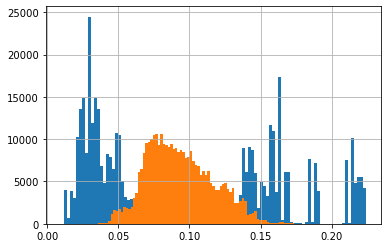

In [10]:
print(data.Market_cap.isna().sum())
print(data.MarketValue_Debt.isna().sum())
data.Cost_of_Debt.hist(bins=100)
data.Cost_of_Capital.hist(bins=100)